## <center><h1 style='color: ##154360; font-size: 70px'>Machine Learning</h1></center>
<center><h2 style='color: #FFC300'>Group Project 37</h2></center>
<center><h3 style='color: #FF5733'>Group Members </h3></center>
<center><h5 style='font-weight:normal; font-style: normal;'>Francisco Antonio, M20200737 </h5></center>
<center><h5 style='font-weight:normal; font-style: normal;'>Ikram Bouziri, M20200753 </h5></center>
<center><h5 style='font-weight:normal; font-style: normal;'>Kelechi Onyealisi, M20201440 </h5></center>
<center><h5 style='font-weight:normal; font-style: normal;'>Gil Francisco Araujo, M20201066 </h5></center>
<center><h5 style='font-weight:normal; font-style: normal;'>Zhenghao Li, M20201007 </h5></center>

<b style='color: ##154360;font-size:19px'>Table of contents</b>
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#Data Processing">Data Processing - Function</a></li>
    <li><a href="#understanding">Data Understanding </a></li>
    <li><a href="#references">References </a></li>
</ul>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier


# Loading Training DataFrame

In [3]:
data = pd.read_excel('Train.xlsx')
data.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


# Data Processing - Function

In [4]:
# Data processing function

def data_processing(data, k = None):
    """
    Takes a pandas data frame, processes and wrangle the data and produce a data frame as output
    """
    ## Replace ? with nans in all the rowns in data_clean
    data.replace("?", np.nan, inplace=True)
    
    #replace NANS
    non_metric_features = ["Native Continent", "Marital Status", "Lives with", "Base Area", "Education Level", "Employment Sector", "Role"]
    metric_features = data.columns.drop(non_metric_features).to_list()
    #in this copy of the dataset we will replace all nans with the mode
    modes = data[non_metric_features].mode().loc[0]
    data.fillna(modes, inplace=True)
    
    ### Drop rows where working hours per week is less than 11 and greater that 80
    if k is None:
        data_to_drop = data[(data["Working Hours per week"] < 10) | (data["Working Hours per week"] > 70)]# | (data["Years of Education"]<5)]

        data_to_drop_percent = ((len(data_to_drop.index))/(len(data.index)))*100
        data_to_drop_percent = "{:.2f}".format(data_to_drop_percent)

        print(f"\n Number of records dropped = \t {len(data_to_drop.index)} \n")
        print(f"\n Percentage of records dropped = \t{data_to_drop_percent}% \n")

        data.drop(data_to_drop.index, inplace=True)
    else:
        pass                                                              
    
    # Clustering "lives with"
    conditionsLW = [
        (data['Lives with'] == 'Alone'),
        (data['Lives with'] == 'Children') | (data['Lives with'] == 'Other relatives'),
        (data['Lives with'] == 'Other Family'),
        (data['Lives with'] == 'Husband') | (data['Lives with'] == 'Wife')
        ]
    # create a list of the values we want to assign for each condition
    valuesLW = ['Alone', 'ChildOtherRelative', 'OtherFamily', 'HusbWife']
    # create a new column and use np.select to assign values to it using our lists as arguments
    data['ClustLiveWith'] = np.select(conditionsLW, valuesLW)
    
    '''
    #data['ClustLiveWith'] = data['Lives with']
    #data["ClustLiveWith"] = np.where(data["ClustLiveWith"].str.contains("Wife") | data["ClustLiveWith"].str.contains("Husband"), 'SO', 'OtherLW')
    '''
    
    # Clustering "Marital Status"
    conditionsMS = [
        (data['Marital Status'] == 'Single') | (data['Marital Status'] == 'Separated'),
        (data['Marital Status'] == 'Widow') | (data['Marital Status'] == 'Divorced') | (data['Marital Status'] == 'Married - Spouse Missing'),
        (data['Marital Status'] == 'Married - Spouse in the Army') | (data['Marital Status'] == 'Married')
        ]
    # create a list of the values we want to assign for each condition
    valuesMS = ['SingleSep', 'WidDivMSM', 'MarriedSIA']
    # create a new column and use np.select to assign values to it using our lists as arguments
    data['ClustMarital'] = np.select(conditionsMS, valuesMS)
    
    '''
    #data['ClustMarital'] = data['Marital Status']
    #data['ClustMarital'] = np.where(data['ClustMarital'].str.contains("Married - Spouse in the Army") | data["ClustMarital"].str.contains("Married"), 'Married-SIA', 'SinglDivorWidow')
    '''
    
    # Native Continent
    conditionsNC = [
        (data['Native Continent'] == 'Africa') | (data['Native Continent'] == 'America'),
        (data['Native Continent'] == 'Asia') | (data['Native Continent'] == 'Europe'),
        (data['Native Continent'] == 'Oceania')
        ]
    # create a list of the values we want to assign for each condition
    valuesNC = ['AfricaAmerica', 'EuroAsia', 'Oceania']
    # create a new column and use np.select to assign values to it using our lists as arguments
    data['ClustContinent'] = np.select(conditionsNC, valuesNC)
    
    
    #Base Area
    conditionsBA = [
        (data['Base Area'] == 'Aberuthven') | (data['Base Area'] == 'Bellmoral') | (data['Base Area'] == 'Cherrytown') | (data['Base Area'] == 'Fanfoss') | (data['Base Area'] == "King's Watch") | (data['Base Area'] == 'Woodpine') | (data['Base Area'] == 'Ironforge') | (data['Base Area'] == 'Mensfield'),
        (data['Base Area'] == 'Auchenshuggle') | (data['Base Area'] == 'Carlisle') | (data['Base Area'] == 'Drumchapel') | (data['Base Area'] == 'Laewaes') | (data['Base Area'] == "Lanercost") | (data['Base Area'] == 'Pran') | (data['Base Area'] == 'Tranmere') | (data['Base Area'] == 'Willesden'),
        (data['Base Area'] == 'Wigston') | (data['Base Area'] == 'Marnmouth') | (data['Base Area'] == 'Conriston'),
        (data['Base Area'] == 'Aerilon') | (data['Base Area'] == 'Bellenau') | (data['Base Area'] == "Fool's March") | (data['Base Area'] == 'Lewes') | (data['Base Area'] == 'Northbury') | (data['Base Area'] == 'Sharpton'),
        (data['Base Area'] == 'Alverton') | (data['Base Area'] == 'Aroonshire') | (data['Base Area'] == 'Butterpond') | (data['Base Area'] == 'Kirkwall') | (data['Base Area'] == "Middlesbrough") | (data['Base Area'] == 'MillerVille') | (data['Base Area'] == 'Orilon') | (data['Base Area'] == 'Redwick Bush') | (data['Base Area'] == 'Watford'),
        (data['Base Area'] == 'Eelry') | (data['Base Area'] == 'Kald') | (data['Base Area'] == "Knife's Edge") | (data['Base Area'] == 'Laenteglos') | (data['Base Area'] == "Sharnwick")
        ]
    # create a list of the values we want to assign for each condition
    valuesBA = ['VeryLowInc', 'LowInc', 'BelowAVGInc', 'AverageInc', 'AboveAVGInc', 'WayAboveAVGInc']
    # create a new column and use np.select to assign values to it using our lists as arguments
    data['ClustBase'] = np.select(conditionsBA, valuesBA)
    
    
    # Employment Sector
    data['Employment Sector'].replace({'Unemployed':'None', 'Never Worked': 'None'}, inplace=True)
    
    '''
    # Age
    data.reset_index(inplace=True)

    # Extract the birthyear from Birthday - this will give a str
    data["Birthyear"] = data.Birthday.str.split(",",expand=True,)[1]

    # conver the str Birthyear to int
    data["Birthyear"] = pd.to_numeric(data["Birthyear"])

    # get the age of the citizens today - year 2048
    data["age"] = DT.date(2048, 1, 1).year - data["Birthyear"]

    # Drop Bithday and Birthyear
    data.drop(['Birthday', "Birthyear"], axis=1, inplace=True)

    data.drop(['index'],axis=1,inplace=True)
    
    # Gender
    data['sex'] = np.where(data["Name"].str.contains("Mr"), 1, 0)
    '''
    data.reset_index(inplace=True)
    data.drop(['index'],axis=1,inplace=True)
    data.drop(['Birthday','Base Area', 'Lives with', 'Marital Status', 'Native Continent', 'Name', 'Education Level'], axis=1, inplace=True)
    
    # Onehotencoding OHC
    non_metric_features = ['ClustContinent','ClustBase',"ClustMarital", "ClustLiveWith", "Employment Sector", "Role"]
    metric_features = data.columns.drop(non_metric_features).to_list()
    
    # Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame
    # with the one-hot encoded categorical features (pass feature names)
    ohc = OneHotEncoder(sparse=False)
    ohc_feat = ohc.fit_transform(data[non_metric_features])
    ohc_feat_names = ohc.get_feature_names()
    ohc_df = pd.DataFrame(ohc_feat, index=data.index, columns=ohc_feat_names) # Why the index=df_ohc.index?
    
    df_ohc = pd.concat([ohc_df, data.drop(columns=non_metric_features)], axis=1)
    clean_data = df_ohc.set_index('CITIZEN_ID')
    
    return clean_data 
    

# Loading and Processing Training DataFrame

In [5]:
data = pd.read_excel('Train.xlsx')
train_data = data_processing(data)
train_data.head()


 Number of records dropped = 	 656 


 Percentage of records dropped = 	2.93% 



,x0_AfricaAmerica,x0_EuroAsia,x0_Oceania,x1_AboveAVGInc,x1_AverageInc,x1_BelowAVGInc,x1_LowInc,x1_VeryLowInc,x1_WayAboveAVGInc,x2_MarriedSIA,...,x5_Professor,x5_Repair & constructions,x5_Sales,x5_Security,x5_Transports,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,13,40,0,2273,1
12487,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,12,40,0,0,1
12488,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,12,46,0,2321,1
12489,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,11,37,5395,0,1
12490,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,21,45,0,0,1


# Split into Train and Test train

In [6]:
data = train_data.drop('Income', axis=1)
target = train_data['Income']

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=40, 
                                                    shuffle=True, 
                                                    stratify=target
                                                   )

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size = 0.25,
                                                  random_state = 40,
                                                  shuffle=True,
                                                  stratify=y_train_val
)

In [10]:
print('train:{}% | validation:{}% | test:{}%'.format(round(len(y_train)/len(target),2),
                                                     round(len(y_val)/len(target),2),
                                                     round(len(y_test)/len(target),2)
                                                    ))

train:0.6% | validation:0.2% | test:0.2%


# GBClassifier

In [10]:
gb = GradientBoostingClassifier(subsample = 1,min_samples_leaf = 1,min_samples_split= 90,learning_rate= 0.1, max_depth=3, n_estimators= 600, random_state = 5)

In [11]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_split=90, n_estimators=600,
                           random_state=5, subsample=1)

In [12]:
y_pred_gb = gb.predict(X_test)

In [13]:
gb_score = gb.score(X_test, y_test)
gb_score

0.8792825936997011

In [14]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3315
           1       0.81      0.65      0.72      1034

    accuracy                           0.88      4349
   macro avg       0.85      0.80      0.82      4349
weighted avg       0.88      0.88      0.87      4349



In [15]:
gb.feature_importances_

array([4.11277947e-04, 3.66279464e-04, 2.32084524e-04, 9.84417589e-04,
       4.65127885e-04, 8.79352866e-04, 8.44616444e-04, 3.94614051e-03,
       7.54818389e-04, 4.87553992e-03, 8.01722206e-03, 2.23847056e-04,
       8.85923490e-04, 2.64749912e-03, 3.70787261e-01, 8.10782295e-04,
       7.97235773e-06, 1.43778655e-03, 1.05432762e-03, 5.71231117e-03,
       1.53144464e-03, 4.33115794e-03, 3.60445720e-03, 1.62339620e-03,
       3.84821638e-03, 9.03655582e-05, 1.87696498e-03, 2.77133634e-05,
       1.69532189e-03, 2.06699407e-03, 2.34429862e-02, 3.18812773e-03,
       2.80155943e-03, 1.02124863e-03, 1.69619675e-03, 1.89615844e-03,
       7.60260941e-04, 2.08298542e-01, 4.77185042e-02, 2.06034164e-01,
       7.71016312e-02])

<AxesSubplot:xlabel='importances', ylabel='features'>

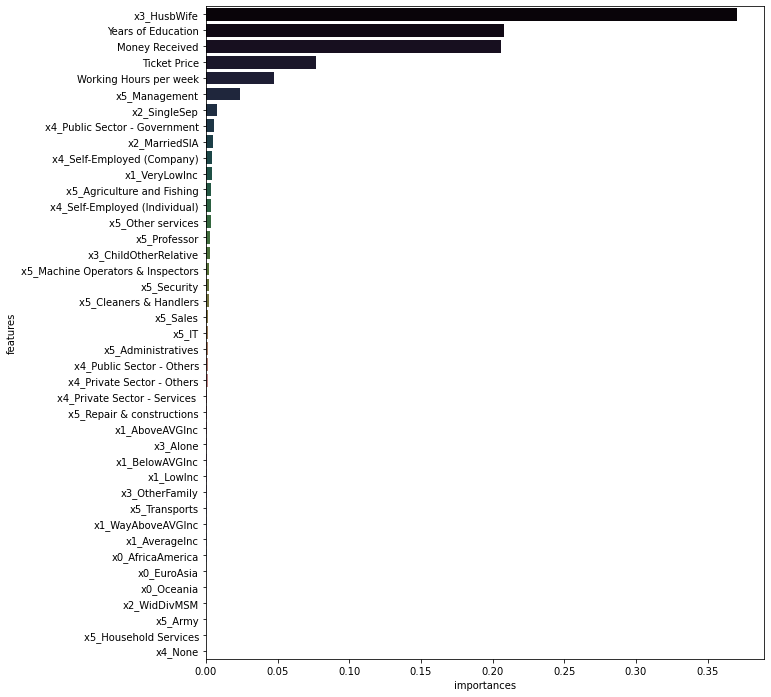

In [16]:
fig = plt.figure(figsize = (10,12))
importances = gb.feature_importances_
features = X_train.columns
data_tuples = list(zip(importances, features))
data_imp = pd.DataFrame(data_tuples, columns = ['importances', 'features'])
data_imp = data_imp.sort_values('importances', ascending = False)
sns.barplot(data_imp['importances'], data_imp['features'], palette = 'cubehelix', orient = 'h')

# TEST MODEL

In [23]:
datatest = pd.read_excel('Test.xlsx')
test_data = data_processing(datatest, k=1)
test_data.head()

,x0_AfricaAmerica,x0_EuroAsia,x0_Oceania,x1_AboveAVGInc,x1_AverageInc,x1_BelowAVGInc,x1_LowInc,x1_VeryLowInc,x1_WayAboveAVGInc,x2_MarriedSIA,...,x5_Other services,x5_Professor,x5_Repair & constructions,x5_Sales,x5_Security,x5_Transports,Years of Education,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
34886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,16,40,0,0
34887,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,16,36,0,0
34888,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13,50,12940,0
34889,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,12,48,0,1827
34890,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,15,45,0,0


In [24]:
model = GradientBoostingClassifier(min_samples_split= 90,learning_rate= 0.1, max_depth=  3.5, n_estimators= 600, random_state = 5)

In [25]:
model.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=3.5, min_samples_split=90,
                           n_estimators=600, random_state=5)

In [26]:
z_pred= model.predict(test_data)

In [27]:
pd.Series(z_pred, index=test_data.index, name='Income').to_csv('Group37_Testx40GBC.csv')